In [313]:
import os
import sys
from pathlib import Path
import ast
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, hstack
# Setting the working directory to the root of the project
project_dir = Path("C:/Users/adbou/source/repos/KFHXRelatedAi/")
os.chdir(project_dir)

from Configs.GeneralPaths import SOURCEDATA
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [314]:
#load redemption deals transactions data
transactions = pd.read_excel(Path(SOURCEDATA / "Redemptions_Transactions_For_Profilings.xlsx"))

In [315]:
transactions.head()

,TrxId,TrxDate,FK_BusinessUserId,PointsRedeemed,EntityName,FK_ContentId,EntityCategory
0,12429817,2023-06-04 11:46:06.050,976480,1000,Alkhalid Clinic,113923,Health and Medical
1,12525687,2023-06-07 14:08:10.287,976480,10000,H&S Store,113853,Electronics and Appliances
2,12525666,2023-06-08 11:03:32.043,976480,10000,H&S Store,113853,Electronics and Appliances
3,12838074,2023-06-22 08:28:30.300,976921,10,Deliveroo Plus,113851,Restaurants and Food Services
4,13587992,2023-07-27 14:41:13.607,976480,50,Mawqif App,113835,Ground Transportation


In [316]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37952 entries, 0 to 37951
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TrxId              37952 non-null  int64         
 1   TrxDate            37952 non-null  datetime64[ns]
 2   FK_BusinessUserId  37952 non-null  int64         
 3   PointsRedeemed     37952 non-null  int64         
 4   EntityName         37952 non-null  object        
 5   FK_ContentId       37952 non-null  int64         
 6   EntityCategory     37952 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 2.0+ MB


In [317]:
# Extracting additional features
transactions['Month'] = transactions['TrxDate'].dt.month
transactions['DayOfWeek'] = transactions['TrxDate'].dt.dayofweek
transactions['Weekday'] = transactions['TrxDate'].dt.weekday
transactions['Weekend'] = transactions['Weekday'] >= 5

In [318]:
# Mapping seasons
def get_season(date):
    year = date.year
    seasons = {'Spring': (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),
               'Summer': (pd.Timestamp(year=year, month=6, day=21), pd.Timestamp(year=year, month=9, day=22)),
               'Autumn': (pd.Timestamp(year=year, month=9, day=23), pd.Timestamp(year=year, month=12, day=20)),
               'Winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year + 1, month=3, day=20))}
    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return season
    return 'Accross Seasons'

In [319]:
transactions['Season'] = transactions['TrxDate'].apply(get_season)

In [320]:
transactions.head()

,TrxId,TrxDate,FK_BusinessUserId,PointsRedeemed,EntityName,FK_ContentId,EntityCategory,Month,DayOfWeek,Weekday,Weekend,Season
0,12429817,2023-06-04 11:46:06.050,976480,1000,Alkhalid Clinic,113923,Health and Medical,6,6,6,True,Spring
1,12525687,2023-06-07 14:08:10.287,976480,10000,H&S Store,113853,Electronics and Appliances,6,2,2,False,Spring
2,12525666,2023-06-08 11:03:32.043,976480,10000,H&S Store,113853,Electronics and Appliances,6,3,3,False,Spring
3,12838074,2023-06-22 08:28:30.300,976921,10,Deliveroo Plus,113851,Restaurants and Food Services,6,3,3,False,Summer
4,13587992,2023-07-27 14:41:13.607,976480,50,Mawqif App,113835,Ground Transportation,7,3,3,False,Summer


In [321]:
content_profiles = transactions.groupby('FK_ContentId').agg({
    'TrxId': 'count',
    'PointsRedeemed': 'sum',
    'Month': lambda x: x.mode()[0],
    'DayOfWeek': lambda x: x.mode()[0],
    'Weekend': lambda x: x.mean(),
    'Season': lambda x: x.mode()[0],
}).reset_index()

In [322]:
content_profiles.rename(columns={
    'TrxId': 'RedemptionCount',
    'PointsRedeemed': 'TotalPointsRedeemed',
    'Month': 'MostCommonMonth',
    'DayOfWeek': 'MostCommonDayOfWeek',
    'Weekend': 'WeekendRedemptionRatio',
    'Season': 'MostCommonSeason'
}, inplace=True)

In [323]:
content_profiles

,FK_ContentId,RedemptionCount,TotalPointsRedeemed,MostCommonMonth,MostCommonDayOfWeek,WeekendRedemptionRatio,MostCommonSeason
0,113816,1,10000,10,2,0.000000,Autumn
1,113817,372,1860000,2,2,0.266129,Accross Seasons
2,113819,2743,8229000,4,6,0.341232,Spring
3,113823,20,20000,4,4,0.300000,Spring
4,113824,17,51000,1,4,0.294118,Accross Seasons
...,...,...,...,...,...,...,...
64,115227,150,525000,4,0,0.260000,Spring
65,115229,1,3500,5,4,0.000000,Spring
66,115231,25,87500,6,4,0.320000,Spring
67,115244,100,100000,3,2,0.000000,Accross Seasons


In [324]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [325]:
scaler = StandardScaler()
transactions['PointsRedeemedScaled'] = scaler.fit_transform(transactions[['PointsRedeemed']])

In [326]:
transactions.head()

,TrxId,TrxDate,FK_BusinessUserId,PointsRedeemed,EntityName,FK_ContentId,EntityCategory,Month,DayOfWeek,Weekday,Weekend,Season,PointsRedeemedScaled
0,12429817,2023-06-04 11:46:06.050,976480,1000,Alkhalid Clinic,113923,Health and Medical,6,6,6,True,Spring,-1.381406
1,12525687,2023-06-07 14:08:10.287,976480,10000,H&S Store,113853,Electronics and Appliances,6,2,2,False,Spring,3.359670
2,12525666,2023-06-08 11:03:32.043,976480,10000,H&S Store,113853,Electronics and Appliances,6,3,3,False,Spring,3.359670
3,12838074,2023-06-22 08:28:30.300,976921,10,Deliveroo Plus,113851,Restaurants and Food Services,6,3,3,False,Summer,-1.902925
4,13587992,2023-07-27 14:41:13.607,976480,50,Mawqif App,113835,Ground Transportation,7,3,3,False,Summer,-1.881853


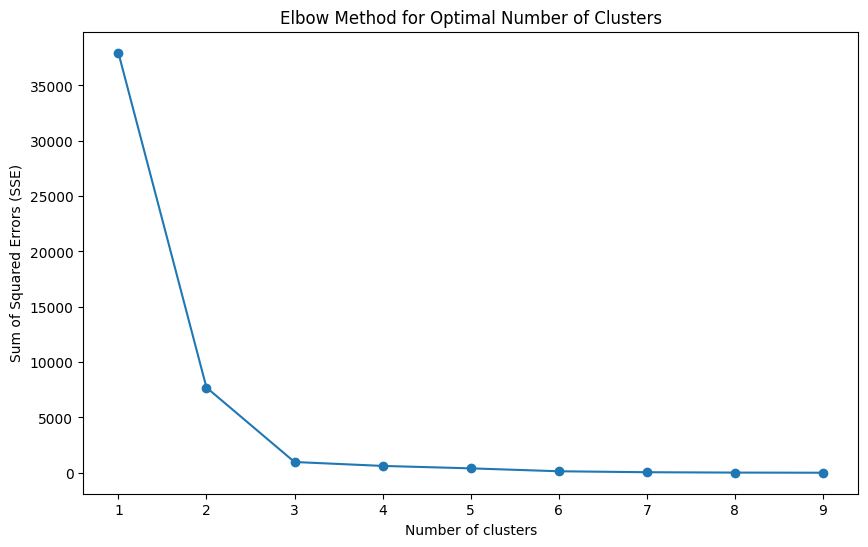

In [327]:
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(transactions[['PointsRedeemedScaled']])
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [328]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
transactions['Cluster'] = kmeans.fit_predict(transactions[['PointsRedeemedScaled']])

cluster_means = transactions.groupby('Cluster')['PointsRedeemed'].mean().sort_values()
cluster_labels = {cluster_means.index[0]: 'Low-Budget Deal', cluster_means.index[1]: 'Medium Budget Deal', cluster_means.index[2]: 'High-End Deal'}
transactions['Deal Value Segment'] = transactions['Cluster'].map(cluster_labels)

In [329]:
# Aggregating data to create content profiles with clustering
content_profiles = transactions.groupby(['FK_ContentId', 'Deal Value Segment' , 'EntityCategory']).agg({
    'TrxId': 'count',
    'PointsRedeemed': 'sum',
    'Month': lambda x: x.mode()[0],
    'DayOfWeek': lambda x: x.mode()[0],
    'Weekend': lambda x: x.mean(),
    'Season': lambda x: x.mode()[0],
}).reset_index()

# Renaming columns for clarity
content_profiles.rename(columns={
    'TrxId': 'RedemptionCount',
    'PointsRedeemed': 'TotalPointsRedeemed',
    'Month': 'MostCommonMonth',
    'DayOfWeek': 'MostCommonDayOfWeek',
    'Weekend': 'WeekendRedemptionRatio',
    'Season': 'MostCommonSeason'
}, inplace=True)

In [330]:
content_profiles

,FK_ContentId,Deal Value Segment,EntityCategory,RedemptionCount,TotalPointsRedeemed,MostCommonMonth,MostCommonDayOfWeek,WeekendRedemptionRatio,MostCommonSeason
0,113816,High-End Deal,Restaurants and Food Services,1,10000,10,2,0.000000,Autumn
1,113817,High-End Deal,Restaurants and Food Services,372,1860000,2,2,0.266129,Accross Seasons
2,113819,Medium Budget Deal,Restaurants and Food Services,2743,8229000,4,6,0.341232,Spring
3,113823,Low-Budget Deal,Travel and Accommodation,20,20000,4,4,0.300000,Spring
4,113824,Medium Budget Deal,Books and Media Stores,17,51000,1,4,0.294118,Accross Seasons
...,...,...,...,...,...,...,...,...,...
64,115227,Medium Budget Deal,Digital Goods-Games,150,525000,4,0,0.260000,Spring
65,115229,Medium Budget Deal,Digital Goods-Market,1,3500,5,4,0.000000,Spring
66,115231,Medium Budget Deal,Digital Goods-Games,25,87500,6,4,0.320000,Spring
67,115244,Low-Budget Deal,Restaurants and Food Services,100,100000,3,2,0.000000,Accross Seasons


In [333]:
popular_categories = content_profiles['EntityCategory'].value_counts().reset_index()
popular_categories.columns = ['EntityCategory', 'Frequency']

print("Most Popular Content Categories:")
print(popular_categories)

Most Popular Content Categories:
                                 EntityCategory  Frequency
0                 Restaurants and Food Services         18
1                           Digital Goods-Games          7
2         Technology and Communication Services          5
3                    Electronics and Appliances          4
4                      Clothing and Accessories          4
5                      Food and Beverage Stores          4
6                          Online Entertainment          3
7                                 Entertainment          3
8                         Ground Transportation          3
9                           Automotive Services          3
10                           Health and Medical          2
11  Personal Services - Health and Beauty Shops          2
12                          Digital Goods-Media          2
13                   Home and Property Services          1
14                     Travel and Accommodation          1
15                     

In [331]:
transactions.head()

,TrxId,TrxDate,FK_BusinessUserId,PointsRedeemed,EntityName,FK_ContentId,EntityCategory,Month,DayOfWeek,Weekday,Weekend,Season,PointsRedeemedScaled,Cluster,Deal Value Segment
0,12429817,2023-06-04 11:46:06.050,976480,1000,Alkhalid Clinic,113923,Health and Medical,6,6,6,True,Spring,-1.381406,1,Low-Budget Deal
1,12525687,2023-06-07 14:08:10.287,976480,10000,H&S Store,113853,Electronics and Appliances,6,2,2,False,Spring,3.359670,0,High-End Deal
2,12525666,2023-06-08 11:03:32.043,976480,10000,H&S Store,113853,Electronics and Appliances,6,3,3,False,Spring,3.359670,0,High-End Deal
3,12838074,2023-06-22 08:28:30.300,976921,10,Deliveroo Plus,113851,Restaurants and Food Services,6,3,3,False,Summer,-1.902925,1,Low-Budget Deal
4,13587992,2023-07-27 14:41:13.607,976480,50,Mawqif App,113835,Ground Transportation,7,3,3,False,Summer,-1.881853,1,Low-Budget Deal


In [334]:
content_profiles.to_excel(Path(SOURCEDATA / "Redemption_Deals_Profiles.xlsx"),index=False)